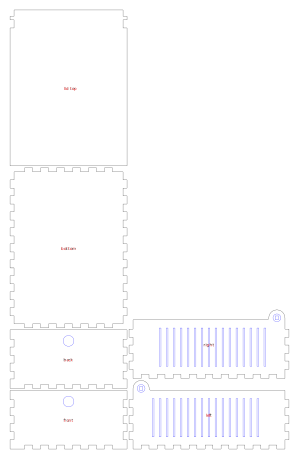

In [20]:
from IPython.display import SVG, display
import numpy as np

import sys
sys.path.append('..') # uncomments and adjust if your Boxes.py copy in not in the Python path
from boxes import *
from boxes import lids
from boxes.edges import Bolts
from boxes.lids import _TopEdge


class MyUniversalBox(_TopEdge):
    """Box with various options for different styles and lids"""

    ui_group = "Box"

    def __init__(self) -> None:
        Boxes.__init__(self)
        self.addTopEdgeSettings(roundedtriangle={"outset" : 1},
                                hinge={"outset" : True})
        self.addSettingsArgs(edges.FlexSettings)
        self.addSettingsArgs(lids.LidSettings)
        self.buildArgParser("top_edge", "bottom_edge",
                            "x", "y", "h", "outside")
        self.argparser.add_argument(
            "--vertical_edges",  action="store", type=str,
            default="finger joints",
            choices=("finger joints", "finger holes"),
            help="connections used for the vertical edges")

    def rect_holes(self, right=False):
        y_offset = 8
        x_offset = 20
        w, h = 2, (height_total - 2 * y_offset)
        x_step = w + 5
        for x in np.arange(x_offset, self.y - x_offset, x_step):
            if right:
                x = self.y - x
            self.rectangularHole(x, y_offset, w, h, center_y=False)
    
    def top_hole(self, x, y, top_edge):
        t = self.thickness

        if top_edge == "f":
            edge = self.edges["F"]
            self.moveTo(2*t+self.burn, 2*t, 90)
        elif top_edge == "F":
            edge = self.edges["f"]
            self.moveTo(t+self.burn, 2*t, 90)
        else:
            raise ValueError("Only f and F supported")

        for l in (y, x, y, x):
            edge(l)
            if top_edge == "F": self.edge(t)
            self.corner(-90)
            if top_edge == "F": self.edge(t)

    def render(self):
        x, y, h = self.x, self.y, self.h
        t = self.thickness

        tl, tb, tr, tf = self.topEdges(self.top_edge)
        b = self.edges.get(self.bottom_edge, self.edges["F"])

        d2 = Bolts(2)
        d3 = Bolts(3)

        d2 = d3 = None

        sideedge = "F" if self.vertical_edges == "finger joints" else "h"

        if self.outside:
            self.x = x = self.adjustSize(x, sideedge, sideedge)
            self.y = y = self.adjustSize(y)
            self.h = h = self.adjustSize(h, b, self.top_edge)

        with self.saved_context():
            callback_front = lambda: self.hole(self.x / 2, height_total - h_extra / 2 - 1, DC55_21_radius)
            self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="front", callback=[callback_front])
            self.rectangularWall(x, h, [b, sideedge, tb, sideedge],
                                 ignore_widths=[1, 6],
                                 bedBolts=[d2], move="up", label="back", callback=[callback_front])

            if self.bottom_edge != "e":
                self.rectangularWall(x, y, "ffff", bedBolts=[d2, d3, d2, d3], move="up", label="bottom")
            if self.top_edge in "fF":
                self.set_source_color(Color.MAGENTA)    # I don't know why this part has a different color, but RED is not a good choice because RED is used for annotations
                self.rectangularWall(x+4*t, y+4*t, callback=[
                    lambda:self.top_hole(x, y, self.top_edge)], move="up", label="top hole")
                self.set_source_color(Color.BLACK)
            self.drawLid(x, y, self.top_edge, [d2, d3])
            self.lid(x, y, self.top_edge)

        self.rectangularWall(x, h, [b, sideedge, tf, sideedge],
                             ignore_widths=[1, 6],
                             bedBolts=[d2], move="right only", label="invisible")
        self.rectangularWall(y, h, [b, "f", tl, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="left", callback=[lambda: self.rect_holes(False)])
        self.rectangularWall(y, h, [b, "f", tr, "f"],
                             ignore_widths=[1, 6],
                             bedBolts=[d3], move="up", label="right", callback=[lambda: self.rect_holes(True)])

height_hex_small = 8  # set to height_hex to support double 18650 sides
thickness = 4.0

DC55_21_radius = 11.0 / 2
board_thickness = 1.5
h_extra = 20 # DC 2.1
height_hex = 25
height_total = height_hex_small + height_hex + board_thickness + h_extra

x, y = 109, 150 + 2

b = MyUniversalBox()
b.parseArgs(['--reference=0', '--debug=0', f'--thickness={thickness}', '--top_edge=i', '--bottom_edge=F', f'--x={x}', f'--y={y}', f'--h={height_total}', '--outside=0', '--Hinge_style=flush'])
#b.parseArgs()
b.open()
b.render()
data = b.close()

with open('boxes_battery_pack.svg', "wb") as f:
    f.write(data.getbuffer())

display(SVG(data=data.getvalue()))